# SCRAPING CHALLENGE

## 1 - VALUE PROPOSTITIONS

Web scraping do Diário Oficial do Município da cidade de Salvador (BA).<br>
Formato de entrega: .json<br><br>
Destaque às ferramentas: bibliotecas do Python e soluções de leitura de texto (OCR/Tesseract, etc.)<br><br>
Esquema:
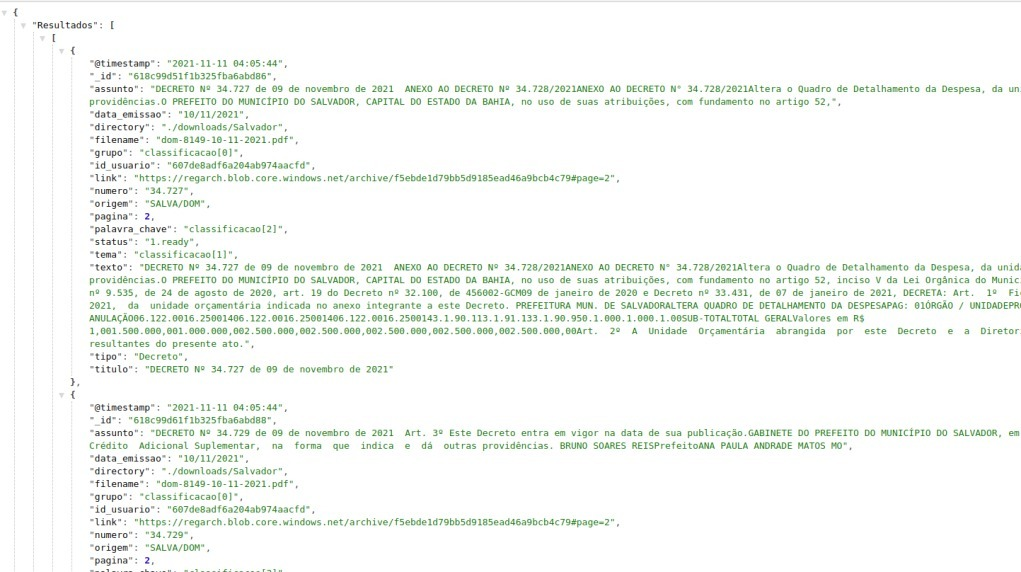

## 2 - Data sources

Os arquivos dos diários oficiais estão em formato PDF dentro do site http://www.dom.salvador.ba.gov.br/
<br>
Desde a primeira publicação até o dia 27-Nov-2021, foram emitidas 8162 edições.<br>
A primeira edição foi publicada em `03 de setembro de 1986` e uma das primeiras etapas do código é obter a associação entre o número do DOM e a data de publicação. Com essa etapa, consegue-se descobrir a data de início das publicações.<br>
Normalmente, uma edição é divulgada em cada dia de semana, com exceção de feriados ou pontes.<br>
Eventuais edições são lançadas em sábados, domingos ou feriados.<br>
Em alguns casos, mais de uma edição do DOM é lançada no mesmo dia, sendo do tipo "EXTRA".<br><br>
Cada PDF está localizado em um endereço que segue um padrão do tipo:<br>
http://www.dom.salvador.ba.gov.br/images/stories/pdf/ `ANO`/`NOME_DO_MES`/`nome_arquivo.pdf`<br>
Sendo:<br>
`ANO`: 4 dígitos que representam o ano.<br>
`NOME_DO_MES`: nome, por extenso, do mês de uma determinada edição, grafado integralmente em letras minúsculas e sem acentos. Especificamente o mês de março-2019 tem sua pasta grafada com a palavra `Marco` contendo a primeira letra maiúscula.<br>
`nome_arquivo.pdf`: nome do arquivo PDF, seguindo um padrão.<br>
Padrão para o nome dos arquivos:<br>
`dom-NÚMERO_DOM-DIA-MES-ANO.pdf` ou `DOM-NÚMERO_DOM-DIA-MES-ANO.pdf`<br><br>
Em que:
`dom` ou `DOM`: a sigla "DOM", escrita com letras maiúsculas (formato mais comum entre 1986 e 2004, assim como nos anos de 2009 a 2012) ou minúsculas (formato mais comum entre 2005 a 2009, bem como a partir de 2013).<br>
`NÚMERO_DOM`: número da edição do DOM, composta de 4 dígitos. Primeira edição: 0001.<br>
`DIA`: dois dígitos representando o dia, variando de 1 até 31. Dias de 1 a 9 são representados com um 0 antes. Ex: 01 e não 1.<br>
`MES`: dois dígitos representando o mês, variando de 1 até 12. Meses de 1 a 9 são representados com um 0 antes.<br>
`ANO`: quatro dígitos representando o ano.<br>

Exemplo: o endereço do diário de número `8104`, publicado no dia `03 de setembro de 2021` será:<br>
http://www.dom.salvador.ba.gov.br/images/stories/pdf/2021/setembro/dom-8104-03-09-2021.pdf

Eventualmente, há erros e exceções nesse padrão, mas essa quantidade corresponde a apenas 0,37% dos casos.

## 3 - Collecting Data

Em primeiro lugar, será gerada uma tabela contendo a relação entre o número de cada DOM, a data da sua emissão e o URL em que a edição se encontra, conforme o modelo abaixo:<br>

|   No_DOM | Data       | URL                                                                                         |
|---------:|:-----------|:--------------------------------------------------------------------------------------------|
|     8164 | 2021-12-01 | http://www.dom.salvador.ba.gov.br/images/stories/pdf/2021/dezembro/dom-8164-01-12-2021.pdf  |
|     8163 | 2021-11-30 | http://www.dom.salvador.ba.gov.br/images/stories/pdf/2021/novembro/dom-8163-30-11-2021.pdf  |
|     8162 | 2021-11-27 | http://www.dom.salvador.ba.gov.br/images/stories/pdf/2021/novembro/dom-8162-27-11-2021.pdf  |
|     8161 | 2021-11-26 | http://www.dom.salvador.ba.gov.br/images/stories/pdf/2021/novembro/dom-8161-26-11-2021.pdf  |
|     8160 | 2021-11-25 | http://www.dom.salvador.ba.gov.br/images/stories/pdf/2021/novembro/dom-8160-25-11-2021.pdf  |

Gerada esta lista, os dados que irão ao arquivo .json serão captados entrando-se em cada um dos URLs que foram encontrados e armazenados na tabela.

Para se gerar a lista que correlaciona número do DOM com data de publicação e URL:
1. Na página inicial do DOM estão disponíveis as 5 edições mais recentes. Começa-se criando a lista com essas 5 edições mais recentes. Faz-se um scraping nesta primeira página.
2. Todos os diários estão contidos em um diretório online relacionado ao seu mês e ano. Na primeira rodagem deste programa, gerou-se a lista de todos os diários, entre a edição 0001 e a edição 8162 a partir do scraping do conteúdo do diretório de cada mês e ano. Para se fazer o scraping da pasta de cada mês, usou-se: `from urllib.request import urlopen` para acessar cada diretório.
3. Procura-se todos os números DOM que estejam ainda faltando na lista, a partir do seu número e testando-se suas possíveis datas de emissão.
4. Salva-se esta lista em um .csv que será usado nas execuções seguintes. Em todas as demais execuções do programa, ao invés de fazer o scraping novamente de toda a base de dados dos diários, apenas se carregará esse .csv, chamado `lista_DOM_datas.csv` e nele serão incrementados os dados dos diários adicionados entre a última execução e a data atual.

### 3.1 Importação das bibliotecas

Bibliotecas de uso geral

In [1]:
# Será usada para se armazenar a relação DOM x Data x URL e diversos outros armazenamentos em tabela
import pandas as pd

# Manipulações numéricas
import numpy as np

# Será usada para manipular as datas
import datetime as dt

# Calcular tempo de execução de partes do código
import time

# Será usada para se formar os nomes por extenso dos meses
import locale
locale.setlocale(locale.LC_ALL, "pt_BR.UTF-8")

'pt_BR.UTF-8'

Bibliotecas que serão usadas para o acesso aos URLs do Diário

In [2]:
# Será usada para tentar abrir cada URL
import urllib.request
from urllib.request import urlopen
import requests

# Tratamentos de exceções
from urllib.error import HTTPError # Definição dos erros HTTPError, para evidenciar erros 404, quando as páginas não existem
from urllib.error import URLError # Definição dos erros URLError, quando as páginas existem, mas há outros erros de acesso

# Biblioteca que será usada para procurar as informações dentro dos códigos-fonte das páginas
from bs4 import BeautifulSoup 

# Tratamento de expressões regulares
import re

In [3]:
# Para as leituras em si dos PDFs
from PyPDF2 import PdfFileReader

# Tratamentos de entrada/saída
import io

### 3.2 Funções auxiliares e variáveis globais

In [4]:
pag_inicial = 'http://www.dom.salvador.ba.gov.br/'

In [5]:
def preenche_iniciais():
    global pag_inicial

    formato_url_dom = '/images/stories/pdf/[0-9]{4}/[a-z]{4,9}/[a-z]{3}\-[0-9]{4}\-[0-9]{2}\-[0-9]{2}\-[0-9]{4}'
    
    dict_DOM_data = {}
    dict_DOM_url = {}
    
    try:
        html = urlopen(pag_inicial)
        bs = BeautifulSoup(html, 'html.parser')
    
    except HTTPError as e:
        print('ERRO HTTPError!')
    
    except URLError as e:
        print('ERRO URLError!')
        
    else:
        todos_URL = list(set(re.findall(formato_url_dom, str(bs))))
        
        for url in todos_URL:
            dom = url[re.search('dom', url).start():][4:8]
            data = url[re.search('dom', url).start():][-10:]
            data = dt.datetime.strptime(data, '%d-%m-%Y').date()
            dict_DOM_data[dom] = data
            dict_DOM_url[dom] = pag_inicial[:-1] + url + '.pdf'
        
    df_inicial = pd.DataFrame(data={'No_DOM':list(dict_DOM_data.keys())})
    
    df_inicial['Data'] = df_inicial.apply(lambda x: dict_DOM_data[x['No_DOM']], axis=1)
    df_inicial['URL'] = df_inicial.apply(lambda x: dict_DOM_url[x['No_DOM']], axis=1)
    
    df_inicial = df_inicial.drop_duplicates()
    
    df_inicial = df_inicial.sort_values(by='No_DOM', ascending=False).reset_index(drop=True)
    
    return df_inicial

In [6]:
def monta_URL_meses(ano_inicio, ano_final, flag_mes_upper=0):
    dict_dir_meses = {}
    
    global pag_inicial
    
    url_comum = pag_inicial + 'images/stories/pdf/'
    
    for ano in range(ano_inicio, ano_final+1):
        for mes in range(1,13):
            nome_per = str(ano).zfill(2) + '-' + str(mes).zfill(2)
            if(dt.datetime(ano, mes, 1).strftime('%B') == 'março'):
                nome_mes = 'marco'
            else:
                nome_mes = dt.datetime(ano, mes, 1).strftime('%B')
            
            if(flag_mes_upper == 0):
                dict_dir_meses[nome_per] = url_comum + str(ano).zfill(4) + '/' + nome_mes
            
            elif(flag_mes_upper == 1):
                dict_dir_meses[nome_per] = url_comum + str(ano).zfill(4) + '/' + nome_mes.title()
    
    return dict_dir_meses

In [7]:
def monta_URL_por_data(no_dom, data, prefixo='http', flag_upper_dom=0, flag_mes_upper=0, flag_mes_dif=0):
    global pag_inicial
    
    url_comum = prefixo + pag_inicial[4:] + 'images/stories/pdf/'
    
    if(flag_mes_dif == 0):
        nome_mes = data.strftime('%B')
        ano_data = str(data.year).zfill(4)
    else:
        if(flag_mes_dif < 0):
            data_ref = dt.date(data.year, data.month, 1) - dt.timedelta(1)
        elif(flag_mes_dif > 0):
            data_ref = dt.date(data.year, data.month, 1) + dt.timedelta(31)
        
        nome_mes = data_ref.strftime('%B')
        ano_data = str(data_ref.year).zfill(4)
    
    nome_dom = 'dom'
    
    
    if(nome_mes == 'março'):
        nome_mes = 'marco'
    
    if(flag_mes_upper == 1):
        nome_mes = nome_mes.title()
        
    if(flag_upper_dom == 1):
        nome_dom = nome_dom.upper()
    
    data_str = data.strftime('%d-%m-%Y')
    
    end_URL = url_comum + ano_data + '/' + nome_mes + '/' + nome_dom + '-' + no_dom + '-' + data_str + '.pdf'
    
    end_URL = end_URL.replace('arço', 'arco')
    
    return end_URL

In [8]:
def verifica_url(download_url):
    a = ''
    try:
        response = urllib.request.urlopen(download_url)    
        #response = urlopen(download_url)    
    
    except HTTPError as e:
        a = 'ERRO HTTPError!'
        
    except URLError as e:
        a = 'ERRO URLError!'
    
    else:
        a = 'SUCESSO'
        
    return a

In [9]:
def busca_mes_a_mes_inicial(df_primeiro):
    dict_URL_meses = monta_URL_meses(1986, 2021)
    
    dict_DOM_url = {}
    dict_DOM_datas = {}
    
    for url_mes in dict_URL_meses:
        try:
            html = urlopen(dict_URL_meses[url_mes])
            bs = BeautifulSoup(html, 'html.parser')
            
        except HTTPError as e:
            print(f'Houve erro do tipo HTTPError ao tentar acessar o URL para o período {url_mes}')
            
        except URLError as e:
            print(f'Houve erro do tipo URLError ao tentar acessar o URL para o período {url_mes}')
            
        else:
            pdf_list = bs.findAll("a")
            for name in pdf_list:
                #print(f'PASSOU POR AQUI - PERÍODO {url_mes}')
                #print(name.get_text())
                if '.pdf' in name.get_text():
                    nome_arquivo = name.get_text()
                    no_dom = nome_arquivo[:8][-4:]
                    data_dom = dt.datetime.strptime(nome_arquivo[-14:][:10], '%d-%m-%Y').date()
                    url_dom = dict_URL_meses[url_mes] + '/' + name.get_text()
                    dict_DOM_url[no_dom] = url_dom
                    dict_DOM_datas[no_dom] = data_dom
                    #print(f'DOM {no_dom} foi publicado na data {data_dom} - URL: {url_dom}')
    
    
    df_mes_a_mes_inicial = pd.DataFrame(data = {'No_DOM':list(dict_DOM_url.keys())})
    
    df_mes_a_mes_inicial['Data'] = df_mes_a_mes_inicial.apply(lambda x: dict_DOM_datas[x['No_DOM']], axis=1)
    df_mes_a_mes_inicial['URL'] = df_mes_a_mes_inicial.apply(lambda x: dict_DOM_url[x['No_DOM']], axis=1)
    
    df_mes_a_mes_inicial = df_mes_a_mes_inicial.append(df_primeiro).sort_values(by='No_DOM', ascending=False).reset_index(drop=True)
    
    return df_mes_a_mes_inicial

In [10]:
# Função que calcula a menor e a maior data possível para um DOM não encontrado
def calcula_menor_maior_data(df, no_dom):
    df_calc = df.copy()

    no_dom_int = int(no_dom)
    
    df_calc = df_calc.rename(columns={'No_DOM':'No_DOM_INT'})
    df_calc['No_DOM_INT'] = df_calc['No_DOM_INT'].astype(int)
    
    data_menor = df_calc.loc[df_calc['No_DOM_INT'] < no_dom_int].sort_values(by='No_DOM_INT', ascending=False).head(1).reset_index(drop=True).iloc[0,1]
    data_maior = df_calc.loc[df_calc['No_DOM_INT'] > no_dom_int].sort_values(by='No_DOM_INT', ascending=True).head(1).reset_index(drop=True).iloc[0,1]
    
    lista_datas = [data_menor, data_maior]
    return lista_datas

In [11]:
# Procurará cada DOM diretamente por seu arquivo PDF, supondo que seu URL segue um padrão igual aos demais
def busca_DOM_faltantes_1(df_completar_1):
    df_com_faltantes_1 = df_completar_1.copy()
    
    dict_DOM_preencher_datas = {}
    dict_DOM_preencher_URL = {}
    
    lista_DOM_possiveis = []
    lista_preenchidos_1 = list(df_com_faltantes_1.iloc[:,0])
    lista_DOM_faltantes_1 = [] # Lista de cada DOM faltante a encontrar
    
    dict_DOM_datas_preenchidos_1 = {list(df_com_faltantes_1.iloc[:,0])[i]: list(df_com_faltantes_1.iloc[:,1])[i] for i in range(len(df_com_faltantes_1))}
    
    dict_DOM_menor_data_poss = {}
    dict_DOM_maior_data_poss = {}
    
    for i in range(1, int(max(df_com_faltantes_1.iloc[:,0])) + 1):
        n_dom_testar = str(i).zfill(4)
        lista_DOM_possiveis.append(n_dom_testar)
        if(n_dom_testar not in lista_preenchidos_1):
            lista_DOM_faltantes_1.append(n_dom_testar)
    
    lista_preenchidos_1.sort()
    lista_preenchidos_1_int = list(map(int, lista_preenchidos_1))
    lista_DOM_faltantes_1.sort()
    lista_DOM_faltantes_1_int = list(map(int, lista_DOM_faltantes_1))
    
    for i in lista_DOM_faltantes_1_int:
        dict_DOM_menor_data_poss[str(i).zfill(4)] = calcula_menor_maior_data(df = df_com_faltantes_1, no_dom = str(i).zfill(4))[0]
        dict_DOM_maior_data_poss[str(i).zfill(4)] = calcula_menor_maior_data(df = df_com_faltantes_1, no_dom = str(i).zfill(4))[1]
#         l_max = []
#         l_min = []
#         for j in lista_preenchidos_1_int:
#             if(j<i):
#                 l_max.append(j)
#             elif(j>i):
#                 l_min.append(j)
#         #print('\n')
#         #print(f'O maior abaixo de {i} vale {max(l_max)}')
#         #print(f'O menor acima de {i} vale {min(l_min)}')
#         dict_DOM_menor_data_poss[str(i).zfill(4)] = dict_DOM_datas_preenchidos_1[str(max(l_max)).zfill(4)]
#         dict_DOM_maior_data_poss[str(i).zfill(4)] = dict_DOM_datas_preenchidos_1[str(min(l_min)).zfill(4)]
#         #print(f'Menor data: {dict_DOM_menor_data_poss[i]}')
#         #print(f'Maior data: {dict_DOM_maior_data_poss[i]}')
        
    for i in dict_DOM_menor_data_poss:
        #print('\n')
        #print(f'DOM número {i} - Menor data: {dict_DOM_menor_data_poss[i]} - Maior data: {dict_DOM_maior_data_poss[i]}')
        #print(f'Diferença entre as datas: {(dict_DOM_maior_data_poss[i] - dict_DOM_menor_data_poss[i]).days} dias')
        
        for j in range((dict_DOM_maior_data_poss[i] - dict_DOM_menor_data_poss[i]).days + 1):
            a = 0 # Contabilizará se a data e o URL foram encontrados para o DOM de número i
            data_testar = dict_DOM_menor_data_poss[i] + dt.timedelta(j)
            
            teste_http_dom = monta_URL_por_data(no_dom=i, prefixo='http',data=data_testar, flag_mes_upper=0, flag_upper_dom=0)
            teste_https_dom = monta_URL_por_data(no_dom=i, prefixo='https',data=data_testar, flag_mes_upper=0, flag_upper_dom=0)
            
            teste_http_DOM = monta_URL_por_data(no_dom=i, prefixo='http',data=data_testar, flag_mes_upper=0, flag_upper_dom=1)
            teste_https_DOM = monta_URL_por_data(no_dom=i, prefixo='https',data=data_testar, flag_mes_upper=0, flag_upper_dom=1)
            
            if((verifica_url(teste_http_dom) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_http_dom
                #print(f'O DOM de número {i} foi publicado no dia {data_testar}\nSeu URL é: {teste_http_dom}')
                a = a + 1
            
            if((verifica_url(teste_https_dom) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_https_dom
                #print(f'O DOM de número {i} foi publicado no dia {data_testar}\nSeu URL é: {teste_https_dom}')
                a = a + 1
                
            
            if((verifica_url(teste_http_DOM) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_http_DOM
                #print(f'O DOM de número {i} foi publicado no dia {data_testar}\nSeu URL é: {teste_http_DOM}')
                a = a + 1
                
            if((verifica_url(teste_https_DOM) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_https_DOM
                #print(f'O DOM de número {i} foi publicado no dia {data_testar}\nSeu URL é: {teste_https_DOM}')
                a = a + 1
            
            if(a>0):
                break
    
    if(len(dict_DOM_preencher_datas) > 0):
        df_preencher = pd.DataFrame(data = {'No_DOM':list(dict_DOM_preencher_datas.keys())})

        df_preencher['Data'] = df_preencher.apply(lambda x: dict_DOM_preencher_datas[x['No_DOM']], axis=1)
        df_preencher['URL'] = df_preencher.apply(lambda x: dict_DOM_preencher_URL[x['No_DOM']], axis=1)

        df_com_faltantes_1 = df_com_faltantes_1.append(df_preencher)
        
        df_com_faltantes_1 = df_com_faltantes_1.drop_duplicates()

        df_com_faltantes_1 = df_com_faltantes_1.sort_values(by = 'No_DOM', ascending=False).reset_index(drop=True)
    
    return df_com_faltantes_1

In [12]:
# Procurará se algum mês não teve sua pasta escrita com letras maiúsculas, em vez de minúsculas
def busca_DOM_faltantes_2(df_completar_2):
    df_com_faltantes_2 = df_completar_2.copy()
    
    dict_DOM_preencher_datas = {}
    dict_DOM_preencher_URL = {}
    
    lista_DOM_possiveis = []
    lista_preenchidos_2 = list(df_com_faltantes_2.iloc[:,0])
    lista_DOM_faltantes_2 = [] # Lista de cada DOM faltante a encontrar
    
    dict_DOM_datas_preenchidos_2 = {list(df_com_faltantes_2.iloc[:,0])[i]: list(df_com_faltantes_2.iloc[:,1])[i] for i in range(len(df_com_faltantes_2))}
    
    dict_DOM_menor_data_poss = {}
    dict_DOM_maior_data_poss = {}
    
    for i in range(1, int(max(df_com_faltantes_2.iloc[:,0])) + 1):
        n_dom_testar = str(i).zfill(4)
        lista_DOM_possiveis.append(n_dom_testar)
        if(n_dom_testar not in lista_preenchidos_2):
            lista_DOM_faltantes_2.append(n_dom_testar)
    
    lista_preenchidos_2.sort()
    lista_preenchidos_2_int = list(map(int, lista_preenchidos_2))
    lista_DOM_faltantes_2.sort()
    lista_DOM_faltantes_2_int = list(map(int, lista_DOM_faltantes_2))
    
    for i in lista_DOM_faltantes_2_int:
        l_max = []
        l_min = []
        for j in lista_preenchidos_2_int:
            if(j<i):
                l_max.append(j)
            elif(j>i):
                l_min.append(j)
        #print('\n')
        #print(f'O maior abaixo de {i} vale {max(l_max)}')
        #print(f'O menor acima de {i} vale {min(l_min)}')
        dict_DOM_menor_data_poss[str(i).zfill(4)] = dict_DOM_datas_preenchidos_2[str(max(l_max)).zfill(4)]
        dict_DOM_maior_data_poss[str(i).zfill(4)] = dict_DOM_datas_preenchidos_2[str(min(l_min)).zfill(4)]
        #print(f'Menor data: {dict_DOM_menor_data_poss[i]}')
        #print(f'Maior data: {dict_DOM_maior_data_poss[i]}')
        
    for i in dict_DOM_menor_data_poss:
        #print('\n')
        #print(f'DOM número {i} - Menor data: {dict_DOM_menor_data_poss[i]} - Maior data: {dict_DOM_maior_data_poss[i]}')
        #print(f'Diferença entre as datas: {(dict_DOM_maior_data_poss[i] - dict_DOM_menor_data_poss[i]).days} dias')
        
        for j in range((dict_DOM_maior_data_poss[i] - dict_DOM_menor_data_poss[i]).days + 1):
            a = 0 # Contabilizará se a data e o URL foram encontrados para o DOM de número i
            data_testar = dict_DOM_menor_data_poss[i] + dt.timedelta(j)
            
            teste_http_dom = monta_URL_por_data(no_dom=i, prefixo='http',data=data_testar, flag_mes_upper=1, flag_upper_dom=0)
            teste_https_dom = monta_URL_por_data(no_dom=i, prefixo='https',data=data_testar, flag_mes_upper=1, flag_upper_dom=0)
            
            teste_http_DOM = monta_URL_por_data(no_dom=i, prefixo='http',data=data_testar, flag_mes_upper=1, flag_upper_dom=1)
            teste_https_DOM = monta_URL_por_data(no_dom=i, prefixo='https',data=data_testar, flag_mes_upper=1, flag_upper_dom=1)
            
            if((verifica_url(teste_http_dom) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_http_dom
                #print(f'O DOM de número {i} foi publicado no dia {data_testar}\nSeu URL é: {teste_http_dom}')
                a = a + 1
            
            if((verifica_url(teste_https_dom) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_https_dom
                #print(f'O DOM de número {i} foi publicado no dia {data_testar}\nSeu URL é: {teste_https_dom}')
                a = a + 1
                
            
            if((verifica_url(teste_http_DOM) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_http_DOM
                #print(f'O DOM de número {i} foi publicado no dia {data_testar}\nSeu URL é: {teste_http_DOM}')
                a = a + 1
                
            if((verifica_url(teste_https_DOM) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_https_DOM
                #print(f'O DOM de número {i} foi publicado no dia {data_testar}\nSeu URL é: {teste_https_DOM}')
                a = a + 1
            
            if(a>0):
                break
    
    if(len(dict_DOM_preencher_datas) > 0):
        df_preencher = pd.DataFrame(data = {'No_DOM':list(dict_DOM_preencher_datas.keys())})

        df_preencher['Data'] = df_preencher.apply(lambda x: dict_DOM_preencher_datas[x['No_DOM']], axis=1)
        df_preencher['URL'] = df_preencher.apply(lambda x: dict_DOM_preencher_URL[x['No_DOM']], axis=1)

        df_com_faltantes_2 = df_com_faltantes_2.append(df_preencher)

        df_com_faltantes_2 = df_com_faltantes_2.drop_duplicates()
        
        df_com_faltantes_2 = df_com_faltantes_2.sort_values(by = 'No_DOM', ascending=False).reset_index(drop=True)
    
    return df_com_faltantes_2

In [13]:
# Procurará se algum DOM faltante foi salvo na pasta do mês errado (anterior ou posterior)
def busca_DOM_faltantes_3(df_completar_3):
    df_com_faltantes_3 = df_completar_3.copy()
    
    dict_DOM_preencher_datas = {}
    dict_DOM_preencher_URL = {}
    
    lista_DOM_possiveis = []
    lista_preenchidos_3 = list(df_com_faltantes_3.iloc[:,0])
    lista_DOM_faltantes_3 = [] # Lista de cada DOM faltante a encontrar
    
    dict_DOM_datas_preenchidos_3 = {list(df_com_faltantes_3.iloc[:,0])[i]: list(df_com_faltantes_3.iloc[:,1])[i] for i in range(len(df_com_faltantes_3))}
    
    dict_DOM_menor_data_poss = {}
    dict_DOM_maior_data_poss = {}
    
    for i in range(1, int(max(df_com_faltantes_3.iloc[:,0])) + 1):
        n_dom_testar = str(i).zfill(4)
        lista_DOM_possiveis.append(n_dom_testar)
        if(n_dom_testar not in lista_preenchidos_3):
            lista_DOM_faltantes_3.append(n_dom_testar)
    
    lista_preenchidos_3.sort()
    lista_preenchidos_3_int = list(map(int, lista_preenchidos_3))
    lista_DOM_faltantes_3.sort()
    lista_DOM_faltantes_3_int = list(map(int, lista_DOM_faltantes_3))
    
    for i in lista_DOM_faltantes_3_int:
        l_max = []
        l_min = []
        for j in lista_preenchidos_3_int:
            if(j<i):
                l_max.append(j)
            elif(j>i):
                l_min.append(j)
        #print('\n')
        #print(f'O maior abaixo de {i} vale {max(l_max)}')
        #print(f'O menor acima de {i} vale {min(l_min)}')
        dict_DOM_menor_data_poss[str(i).zfill(4)] = dict_DOM_datas_preenchidos_3[str(max(l_max)).zfill(4)]
        dict_DOM_maior_data_poss[str(i).zfill(4)] = dict_DOM_datas_preenchidos_3[str(min(l_min)).zfill(4)]
        #print(f'Menor data: {dict_DOM_menor_data_poss[i]}')
        #print(f'Maior data: {dict_DOM_maior_data_poss[i]}')
        
    for i in dict_DOM_menor_data_poss:
        #print('\n')
        #print(f'DOM número {i} - Menor data: {dict_DOM_menor_data_poss[i]} - Maior data: {dict_DOM_maior_data_poss[i]}')
        #print(f'Diferença entre as datas: {(dict_DOM_maior_data_poss[i] - dict_DOM_menor_data_poss[i]).days} dias')
        
        for j in range((dict_DOM_maior_data_poss[i] - dict_DOM_menor_data_poss[i]).days + 1):
            a = 0 # Contabilizará se a data e o URL foram encontrados para o DOM de número i
            data_testar = dict_DOM_menor_data_poss[i] + dt.timedelta(j)
            
            teste_http_dom_antes = monta_URL_por_data(no_dom=i, prefixo='http',data=data_testar, flag_mes_dif=-1, flag_upper_dom=0)
            teste_https_dom_antes = monta_URL_por_data(no_dom=i, prefixo='https',data=data_testar, flag_mes_dif=-1, flag_upper_dom=0)
            
            teste_http_DOM_antes = monta_URL_por_data(no_dom=i, prefixo='http',data=data_testar, flag_mes_dif=-1, flag_upper_dom=1)
            teste_https_DOM_antes = monta_URL_por_data(no_dom=i, prefixo='https',data=data_testar, flag_mes_dif=-1, flag_upper_dom=1)
            
            teste_http_dom_depois = monta_URL_por_data(no_dom=i, prefixo='http',data=data_testar, flag_mes_dif=1, flag_upper_dom=0)
            teste_https_dom_depois = monta_URL_por_data(no_dom=i, prefixo='https',data=data_testar, flag_mes_dif=1, flag_upper_dom=0)
            
            teste_http_DOM_depois = monta_URL_por_data(no_dom=i, prefixo='http',data=data_testar, flag_mes_dif=1, flag_upper_dom=1)
            teste_https_DOM_depois = monta_URL_por_data(no_dom=i, prefixo='https',data=data_testar, flag_mes_dif=1, flag_upper_dom=1)
            
            if((verifica_url(teste_http_dom_antes) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_http_dom_antes
                a = a + 1
            
            if((verifica_url(teste_https_dom_antes) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_https_dom_antes
                a = a + 1
                
            
            if((verifica_url(teste_http_DOM_antes) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_http_DOM_antes
                a = a + 1
                
            if((verifica_url(teste_https_DOM_antes) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_https_DOM_antes
                a = a + 1
                
            if((verifica_url(teste_http_dom_depois) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_http_dom_depois
                a = a + 1
            
            if((verifica_url(teste_https_dom_depois) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_https_dom_depois
                a = a + 1
                
            
            if((verifica_url(teste_http_DOM_depois) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_http_DOM_depois
                a = a + 1
                
            if((verifica_url(teste_https_DOM_depois) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_https_DOM_depois
                a = a + 1
            
            if(a>0):
                break
    
    if(len(dict_DOM_preencher_datas) > 0):
        df_preencher = pd.DataFrame(data = {'No_DOM':list(dict_DOM_preencher_datas.keys())})

        df_preencher['Data'] = df_preencher.apply(lambda x: dict_DOM_preencher_datas[x['No_DOM']], axis=1)
        df_preencher['URL'] = df_preencher.apply(lambda x: dict_DOM_preencher_URL[x['No_DOM']], axis=1)

        df_com_faltantes_3 = df_com_faltantes_3.append(df_preencher)

        df_com_faltantes_3 = df_com_faltantes_3.drop_duplicates()
        
        df_com_faltantes_3 = df_com_faltantes_3.sort_values(by = 'No_DOM', ascending=False).reset_index(drop=True)
    
    return df_com_faltantes_3

In [14]:
# Procurará a correção para erros isolados
def busca_DOM_faltantes_4(df_completar_4):
    df_com_faltantes_4 = df_completar_4.copy()
    
    lista_DOM_faltantes_4 = [] # Lista de cada DOM faltante a encontrar
    
    #print(max(df_com_faltantes_4.iloc[:,0]))
    
    df_com_faltantes_4 = df_com_faltantes_4.drop_duplicates()
    
    return df_com_faltantes_4

In [15]:
# Função que testa se o arquivo .csv existente não está corrompido ou com alguma informação inválida
def testa_integridade_csv(df_csv):
    flag_retorno = False
    
    df_csv['Data'] = pd.to_datetime(df_csv['Data'], format='%Y-%m-%d',errors='coerce')
    
    df_teste = df_csv.copy()
    
    # Testa se a maior parte dos exemplares dos diários está com suas informações preenchidas
    # Critério usado: mínimo mais de 90% dos diários entre 0001 e 8162
    tamanho_base = len(df_teste)
    cond1 = ((tamanho_base / 8162) > 0.9)
    if(cond1 == False):
        print(f'A base está com muitos registros faltando - Apenas {tamanho_base}')
        return flag_retorno
    
    # Testa se os nomes das colunas no .csv encontrado não foram mudados
    nomes_colunas = df_teste.columns
    cond2 = (len(nomes_colunas) == 3)
    cond2 = cond2 & (nomes_colunas[0] == 'No_DOM') & (nomes_colunas[1] == 'Data') & (nomes_colunas[2] == 'URL')
    if(cond2 == False):
        print('Ao menos uma coluna está com o nome incorreto')
        return flag_retorno
    
    # Testa se todos os números de DOM estão preenchidos corretamente
    cond3 = True
    cond3 = cond3 & (df_teste['No_DOM'].dtype == 'int64')
    if(cond3 == False):
        return flag_retorno
    
    # Testa se todos os campos de data estão realmente com datas
    cond4 = True
    
    if(len(df_teste[df_teste['Data'].isnull()]) > 0):
        print('Ao menos uma data está incorreta - nova base será carregada')
        return flag_retorno
    
    for i in range(len(df_teste)):
        cond4 = cond4 & (type(df_teste.iloc[i,1].date()) == type(dt.date(2021,1,1))) # A linha está realmente com um campo tipo data?
        cond4 = cond4 & (df_teste.iloc[i,1].date() >= dt.date(1986,9,3)) # A data é maior do que a data do primeiro DOM?
        cond4 = cond4 & (df_teste.iloc[i,1].date() <= dt.date.today()) # A data é menor do que a data de hoje?
        #cond4 = cond4 & (df_teste.iloc[i,1].isna()) # Houve erro na leitura?
        if(cond4 == False):
            print(f'Verificar o registro do DOM de número {df_teste.iloc[i,0]} - Data incorreta - {df_teste.iloc[i,1]}')
            return flag_retorno
    
    # Testa se todos os endereços URL estão no formato correto
    # Caso algum dos endereços não tenha uma indicação de .pdf, http ou https, irá se considerar que há erro
    cond5 = True
    
    for i in range(len(df_teste)):
        cond5 = cond5 & ('http' in df_teste.iloc[i,2])
        cond5 = cond5 & ('pdf' in df_teste.iloc[i,2])
        if(cond5 == False):
            print(f'Verificar o registro do DOM de número {df_teste.iloc[i,0]} - URL incorreto')
            return flag_retorno
    
    flag_retorno = (cond1 & cond2 & cond3 & cond4 & cond5)
    
    return flag_retorno

In [16]:
def testa_se_ha_csv(file_csv):
    from os.path import exists
    
    flag_retorno = False
    
    if exists(file_csv): # Testa se a maioria das linhas está na base
        flag_retorno = testa_integridade_csv(pd.read_csv(file_csv))
        
    return flag_retorno

In [17]:
def monta_1a_base():
    df_1a_base = preenche_iniciais()
    
    # Acrescenta ao DataFrame as informações sobre o 1o lote de endereços
    # Extrai o conteúdo da pasta de cada mês
    df_1a_base = busca_mes_a_mes_inicial(df_1a_base)
    
    # Acrescenta ao DataFrame as informações sobre os DOM's que não foram encontrados na 1a busca
    # Busca os números de DOM que não foram encontrados pela função anterior e procura montar seus endereços
    # procurando-se nas pastas das datas mais prováveis
    # Montam-se os URLs conforme o padrão já detectado
    df_1a_base = busca_DOM_faltantes_1(df_1a_base)
    
    # Acrescenta ao DataFrame as informações sobre os DOM's que não foram encontrados na 2a busca
    # Procura possíveis erros sistêmicos na montagem do endereço de cada arquivo PDF
    df_1a_base = busca_DOM_faltantes_2(df_1a_base)
    
    # Acrescenta ao DataFrame as informações sobre os DOM's que não foram encontrados na 3a busca
    # Procura os DOMs que foram salvos em um diretório errado
    df_1a_base = busca_DOM_faltantes_3(df_1a_base)
    
    # Acrescenta ao DataFrame as informações sobre os DOM's que não foram encontrados na 4a busca
    # Procura corrigir erros isolados
    df_1a_base = busca_DOM_faltantes_4(df_1a_base)
    
    return df_1a_base

In [18]:
def testa_todos_possiveis(no_dom, data):
    if(type(no_dom) == type(8000)):
        no_dom = str(no_dom).zfill(4)
    
    lista_URLs_testar = []
    info_correto = []
    
    dict_prefixo = {0:'http', 12:'https'}
    dict_ant_post = {0:-1, 1:0, 2:1}
    
    for i in range(24):
        prefixo_usar = dict_prefixo[(i - i%12)]
        flag_DOM = int((i - i%6)/6)%2
        flag_mes = int((i - i%3)/3)%2
        flag_mes_dif = dict_ant_post[i%3]
        lista_URLs_testar.append(monta_URL_por_data(no_dom, data, prefixo=prefixo_usar, flag_upper_dom=flag_DOM, flag_mes_upper=flag_mes, flag_mes_dif=flag_mes_dif))
    
    a = 0 # Quantidade de vezes em que um endereço deu certo

    for URL_testar in lista_URLs_testar:
        if(verifica_url(URL_testar) == 'SUCESSO'):
            a = a + 1
            info_correto.clear()
            info_correto.append('SUCESSO')
            info_correto.append(URL_testar)
        
        if(a > 0):
            break
    
    if(a == 0):
        info_correto = ['NENHUM', 'NENHUM']
    
    return info_correto

In [19]:
def converte_pd_timestamp(timestamp):
    data_correta_txt = timestamp.strftime('%Y-%m-%d')
    ano = data_correta_txt[:4]
    mes = data_correta_txt[:7][-2:]
    dia = data_correta_txt[-2:]
    data_correta = dt.date(int(ano), int(mes), int(dia))
    return data_correta

In [20]:
# Função que irá procurar se entre a última execução e a execução atual foram publicadas novas edições do DOM
# Caso haja novas edições, serão atualizadas na base
def atualiza_base(df_a_atualizar, contador=0, inicio=0):
    if(contador==0):
        inicio = time.time()
    ultimo_DOM = max(df_a_atualizar['No_DOM'])
    dia_hoje = dt.date.today()
    data_ultimo_DOM = df_a_atualizar.iloc[df_a_atualizar[df_a_atualizar['No_DOM'] == ultimo_DOM].index[0], 1]
    data_ultimo_DOM = converte_pd_timestamp(data_ultimo_DOM)
    
    dict_DOM_datas_incluir = {}
    dict_DOM_URL_incluir = {}
    
    DOM_testar = str(int(ultimo_DOM) + 1).zfill(4)
    
    for i in range((dia_hoje - data_ultimo_DOM).days + 1):
        data_teste = data_ultimo_DOM + dt.timedelta(i)
        if(testa_todos_possiveis(DOM_testar, data_teste)[0] == 'SUCESSO'):
            URL_found = testa_todos_possiveis(DOM_testar, data_teste)[1]
            dict_DOM_datas_incluir[DOM_testar] = data_teste
            dict_DOM_URL_incluir[DOM_testar] = URL_found
            break
    
    if(len(dict_DOM_URL_incluir) > 0 ):
        df_incluir = pd.DataFrame({'No_DOM':[DOM_testar], 'Data':[data_teste], 'URL':testa_todos_possiveis(DOM_testar, data_teste)[1]})

        df_a_atualizar = df_a_atualizar.append(df_incluir)
        df_a_atualizar = df_a_atualizar.drop_duplicates()

        df_a_atualizar = df_a_atualizar.sort_values(by = 'No_DOM', ascending=False).reset_index(drop=True)

        contador = contador+1
        df_a_atualizar = atualiza_base(df_a_atualizar, contador=contador, inicio=inicio)

        df_atualizada = df_a_atualizar.copy()
    
    if(data_ultimo_DOM < dt.date.today() - dt.timedelta(5)):
        contador = contador+1
        df_a_atualizar = atualiza_base(df_a_atualizar, contador=contador, inicio=inicio)
    
    final = time.time()
    print(f'Tempo total de execução: {int(round(final-inicio,0))} segundos - {int(round((final-inicio)/60,0))} minutos')
    df_atualizada = df_a_atualizar.copy()
    
    for i in range(len(df_atualizada)):
        if(type(df_atualizada.iloc[i,1] != type(dt.date.today()))):
            df_atualizada.iloc[i,1] = converte_pd_timestamp(df_atualizada.iloc[i,1])
    
    return df_atualizada

In [21]:
def extrai_n_dom_do_URL(url):
    if(re.search('/dom', url) != None):
        n_dom = url[re.search('/dom', url).start():][5:9]
        return n_dom
    else:
        return 'ERRO'

def extrai_data_URL(url):
    exp_data = '[0-9]{2}\-[0-9]{2}\-[0-9]{4}'
    
    if(re.search(exp_data, url) != None):
        data = url[re.search(exp_data, url).start():][:10]
        data = dt.datetime.strptime(data, '%d-%m-%Y').date()
        return data
    else:
        return dt.date(1900,1,1)

In [22]:
def info_creators(url_pdf):
    response = requests.get(url_pdf)
    
    creator_status = ''
    
    if(response.status_code != 200):
        print(f'\nHÁ ALGUM ERRO AO TENTAR ACESSAR O DOM {extrai_n_dom_do_URL(url_pdf)}')
        creator_status = 'ERRO'
        return creator_status
    
    with io.BytesIO(response.content) as f:
        try:
            pdf_DOM = PdfFileReader(f)
        except:
            creator_status = 'ERRO'
        else:
            creator_status = pdf_DOM.getDocumentInfo()['/Creator']
        
    return creator_status

In [23]:
def caracteres_pdf(url_pdf):
    inicio = time.time()
    response = requests.get(url_pdf)
    
    num_caract = 0
    
    if(response.status_code != 200):
        print(f'\nHÁ ALGUM ERRO AO TENTAR ACESSAR O DOM {extrai_n_dom_do_URL(url_pdf)}')
        creator_status = 'ERRO'
        return creator_status
    
    with io.BytesIO(response.content) as f:
        try:
            pdf_DOM = PdfFileReader(f)
        
        except:
            creator_status = 'ERRO'
        
        else:
            #creator_status = pdf_DOM.getDocumentInfo()['/Creator']
            num_pag = pdf_DOM.getNumPages()
            creator_status = 'PASSOU POR AQUI'
            #print(f'{creator_status} - O PDF tem {num_pag} páginas')
            for i in range(num_pag):
                num_car_pag = len(pdf_DOM.getPage(i).extractText())
                num_caract = num_caract + num_car_pag
                #print(f'Página {i} possui {num_car_pag} caracteres')
            
            cppag = num_caract / num_pag
            #print(f'O PDF desse DOM possui {cppag} caracteres por página')
            
            if(cppag > 50):
                creator_status = 'OCR PARCIAL'
            
            else:
                creator_status = 'SEM OCR'
    
    #print(f'Status OK - {creator_status} - Tempo de execução: {round(time.time() - inicio, 0)} segundos')
    return creator_status

In [24]:
def calcula_texto(df_calcular):
    from os.path import exists
    
    df_calculado = df_calcular.copy()
    csv_teste_ocr = '../aux_files/lista_DOM_PDF_creators.csv'
    lista_preencher = [] # lista que terá os números de DOM que ainda precisam ser preenchidos
    flag_csv = False
    
    if(exists(csv_teste_ocr)):
        print('A PARTIR DE ONDE PAROU')
        df_csv = pd.read_csv(csv_teste_ocr)
        df_csv['No_DOM'] = df_csv['No_DOM'].astype(str).str.zfill(4)
        
        for col in list(df_csv.columns):
            if(col not in list(df_calculado.columns)):
                df_calculado[col] = ''
        
        df_calculado = pd.merge(df_calculado.iloc[:,[0,1,2]], df_csv.iloc[:,[0,2]], on='No_DOM', how='left')
        df_preencher = df_calculado.loc[df_calculado['Creator'].isna()]
        
    else:
        print('CRIAR LISTA DO ZERO')
        df_preencher = df_calcular.copy()
        df_preencher['Creator'] = ''
    
    for dom in df_preencher['No_DOM']:
        ind_dom = df_calculado.loc[df_calculado['No_DOM'] == dom].index[0]
        url_dom = df_calculado.iloc[ind_dom, 2]
        df_calculado.iloc[ind_dom, 3] = info_creators(url_dom)
    
    df_calculado.insert(loc=4, column='First', value = list(df_calculado['Creator'].str.split(' ', expand=True).iloc[:,0]))
    df_calculado['First'] = df_calculado['First'].str.upper()
    
    
    df_calculado['TEXTO'] = ''
    df_calculado['REQUER_OCR'] = ''
    
    df_calculado.loc[df_calculado['First'] == 'ADOBE', ['TEXTO', 'REQUER_OCR']] = ['TEXTO FEITO EM PDF', 'TEXTO FEITO EM PDF']
    df_calculado.loc[df_calculado['First'] == 'PSCRIPT5.DLL', ['TEXTO', 'REQUER_OCR']] = ['TEXTO FEITO EM PDF', 'TEXTO FEITO EM PDF']
    
    df_calculado.loc[df_calculado['First'] == 'ERRO', ['TEXTO', 'REQUER_OCR']] = ['ERRO DE LEITURA', 'ERRO DE LEITURA']
    
    df_calculado.loc[df_calculado['First'] == 'FUJITSU', 'TEXTO'] = 'IMAGEM DIGITALIZADA'
    df_calculado.loc[df_calculado['First'] == 'HP', 'TEXTO'] = 'IMAGEM DIGITALIZADA'
    df_calculado.loc[df_calculado['First'] == 'ADVANCED', 'TEXTO'] = 'IMAGEM DIGITALIZADA'
    df_calculado.loc[df_calculado['First'] == 'SCANDALL', 'TEXTO'] = 'IMAGEM DIGITALIZADA'
    
    df_calculado = df_calculado.drop(columns='First')
    
    return df_calculado

In [25]:
def calcula_ocr(df_calcular):
    from os.path import exists
    
    df_calculado = df_calcular.copy()
    
    csv_teste_ocr_status = '../aux_files/lista_DOM_OCR.csv'
    #lista_preencher = [] # lista que terá os números de DOM que ainda precisam ser preenchidos
    flag_csv_status = False
    
    if(exists(csv_teste_ocr_status)):
        print('A PARTIR DE ONDE PAROU')
        df_csv = pd.read_csv(csv_teste_ocr_status)
        df_csv['No_DOM'] = df_csv['No_DOM'].astype(str).str.zfill(4)
        df_csv['Data'] = pd.to_datetime(df_csv['Data'], format='%Y-%m-%d').dt.date
        dom_imdig = list(df_csv.loc[(df_csv['REQUER_OCR'] == '') | (df_csv['REQUER_OCR'].isna())].iloc[:,0])
        
        for dom in list(df_calculado['No_DOM']):
            ind_dom_calc = df_calculado.loc[df_calculado['No_DOM'] == dom].index[0]
            if dom in list(df_csv['No_DOM']):
                #print(f'DOM {dom} ESTÁ NO CSV')
                ind_dom_csv = df_csv.loc[df_csv['No_DOM'] == dom].index[0]
                df_calculado.iloc[ind_dom_calc, 5] = df_csv.iloc[ind_dom_csv, 5]
    
    else:
        dom_imdig = list(df_calculado.loc[df_calculado['REQUER_OCR'] == ''].iloc[:,0])
    
    #dom_imdig = list(df_calculado.loc[df_calculado['REQUER_OCR'] == ''].iloc[:,0])
    
    #for dom in dom_imdig:
    if(len(dom_imdig) > 0):
        for dom in dom_imdig:
            ind_dom = df_calculado.loc[df_calculado['No_DOM'] == dom].index[0]
            url_dom = df_calculado.iloc[ind_dom, 2]
            print(f'O DOM de número {dom} precisa de análise sobre o seu OCR - seu índice é {ind_dom}')
            df_calculado.iloc[ind_dom, 5] = caracteres_pdf(url_dom)

            df_calculado.to_csv('../aux_files/lista_DOM_OCR.csv', index=False)
    
    
    df_calculado.to_csv('../aux_files/lista_DOM_OCR.csv', index=False)
    return df_calculado

Funções para extração dos textos dos PDFs e gravação no .json

In [26]:
# FAZER AJUSTES NESTA FUNÇÃO
def procura_categorias(texto_total):
    lista_cat = ['DECRETO Nº',
                 'ANEXO AO DECRETO Nº',
                'PORTARIA Nº',
                'AVISO DE ',
                'RESULTADO ',
                'DISPENSA DE LICITAÇÃO Nº',
                'RESUMO DE',
                'RESUMO DO',
                'AUTORIZAÇÃO ',
                'RETIFICAÇÃO ',
                'TORNAR SEM EFEITO',
                'TERMO DE ',
                'EDITAL DE',
                'LEI Nº',
                'FICHA CADASTRAL',
                'DESPACHO',
                'RELAÇÃO DE AUTOS',
                'COMUNICADO',
                'PREGÃO ELETRÔNICO']
    
    indices_lim = []
    titulos = []
    textos = []
    
    dict_ind_tit = {}
    dict_ind_txt = {}
    
    texto = 'TEXTO_INICIAL_FUNCAO'
    
    for categoria in lista_cat:
        re_proc = categoria + '\s[(\w) | (\.) | (/) | (^\w)]+'

        for i in range(len(texto_total)):
            if(re.match(re_proc, texto_total[i]) != None):
                indices_lim.append(i)
                titulos.append(texto_total[i])
                dict_ind_tit[i] = texto_total[i]
                
    indices_lim.sort()
    print(f'Os índices máximo e mínimo são: {min(indices_lim)} e {max(indices_lim)}')
    for i in range(len(texto_total)):
        if(i >= min(indices_lim)):
            if i in indices_lim:
                if(texto == 'TEXTO_INICIAL_FUNCAO'):
                    ind_usar = i
                    texto = texto_total[i]
                else:
                    textos.append(texto)
                    dict_ind_txt[ind_usar] = texto
                    ind_usar = i
                    texto = texto_total[i]
            else:
                texto = texto + ' ' + texto_total[i]
                if(i == (len(texto_total) - 1)):
                    textos.append(texto)
                    dict_ind_txt[ind_usar] = texto
                
    #print(f'OS ÍNDICES ONDE HÁ UM DELIMITADOR SÃO: {len(indices_lim)} REGISTROS \n{indices_lim}')
    #print(f'\nOS TÍTULOS DOS REGISTROS FORAM: {len(titulos)} REGISTROS\n{titulos}')
    #print(f'\nOS TEXTOS DOS REGISTROS FORAM: {len(textos)} REGISTROS\n{textos}')
    
    df_registros = pd.DataFrame(data = {'INDICE':list(dict_ind_tit.keys())})
    df_registros['TITULOS'] = df_registros.apply(lambda x: dict_ind_tit[x['INDICE']], axis=1)
    df_registros['TEXTOS'] = df_registros.apply(lambda x: dict_ind_txt[x['INDICE']], axis=1)
    
    return df_registros

### 3.3 Carregamento da base de dados

In [27]:
# Testa-se se já há um arquivo prévio com uma base de dados e que seja válida
# Caso já haja uma base carregada e seja válida, essa base será usada e apenas atualizada
# Caso não haja nenhuma, será montada uma primeira base de dados
file_csv = '../aux_files/lista_DOM_datas.csv'

if testa_se_ha_csv(file_csv):
    #print('EXECUTOU POR AQUI - CARREGAMENTO DO ARQUIVO BASE')
    df_base = pd.read_csv(file_csv)
    df_base['No_DOM'] = df_base['No_DOM'].astype(str).str.zfill(4)
    df_base['Data'] = pd.to_datetime(df_base['Data'], format='%Y-%m-%d')
    
else:
    #print('EXECUTOU POR AQUI - CONSTRUIU A NOVA BASE')
    df_base = monta_1a_base()
    #df_base.to_csv(file_csv, index=False)

In [28]:
df_base

No_DOM       Data                                                URL
0      8169 2021-12-08  http://www.dom.salvador.ba.gov.br/images/stori...
1      8168 2021-12-07  http://www.dom.salvador.ba.gov.br/images/stori...
2      8167 2021-12-04  http://www.dom.salvador.ba.gov.br/images/stori...
3      8166 2021-12-03  http://www.dom.salvador.ba.gov.br/images/stori...
4      8165 2021-12-02  http://www.dom.salvador.ba.gov.br/images/stori...
...     ...        ...                                                ...
8157   0005 1986-09-12  http://www.dom.salvador.ba.gov.br/images/stori...
8158   0004 1986-09-10  http://www.dom.salvador.ba.gov.br/images/stori...
8159   0003 1986-09-08  http://www.dom.salvador.ba.gov.br/images/stori...
8160   0002 1986-09-05  http://www.dom.salvador.ba.gov.br/images/stori...
8161   0001 1986-09-03  http://www.dom.salvador.ba.gov.br/images/stori...

[8162 rows x 3 columns]

In [29]:
# Atualiza a base
df_base = atualiza_base(df_base);

C:\Users\User\anaconda3\lib\site-packages\pandas\core\algorithms.py:563: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  uniques, codes = table.factorize(


Tempo total de execução: 2230 segundos - 37 minutos
Tempo total de execução: 2232 segundos - 37 minutos
Tempo total de execução: 2233 segundos - 37 minutos
Tempo total de execução: 2300 segundos - 38 minutos
Tempo total de execução: 2302 segundos - 38 minutos
Tempo total de execução: 2330 segundos - 39 minutos
Tempo total de execução: 2332 segundos - 39 minutos
Tempo total de execução: 2414 segundos - 40 minutos
Tempo total de execução: 2416 segundos - 40 minutos
Tempo total de execução: 2446 segundos - 41 minutos
Tempo total de execução: 2447 segundos - 41 minutos
Tempo total de execução: 2520 segundos - 42 minutos
Tempo total de execução: 2521 segundos - 42 minutos
Tempo total de execução: 2580 segundos - 43 minutos
Tempo total de execução: 2582 segundos - 43 minutos
Tempo total de execução: 2661 segundos - 44 minutos
Tempo total de execução: 2663 segundos - 44 minutos
Tempo total de execução: 2686 segundos - 45 minutos
Tempo total de execução: 2688 segundos - 45 minutos
Tempo total 

In [30]:
df_base

No_DOM        Data                                                URL
0      8220  2022-02-10  http://www.dom.salvador.ba.gov.br/images/stori...
1      8219  2022-02-09  http://www.dom.salvador.ba.gov.br/images/stori...
2      8218  2022-02-08  http://www.dom.salvador.ba.gov.br/images/stori...
3      8217  2022-02-05  http://www.dom.salvador.ba.gov.br/images/stori...
4      8216  2022-02-04  http://www.dom.salvador.ba.gov.br/images/stori...
...     ...         ...                                                ...
8208   0005  1986-09-12  http://www.dom.salvador.ba.gov.br/images/stori...
8209   0004  1986-09-10  http://www.dom.salvador.ba.gov.br/images/stori...
8210   0003  1986-09-08  http://www.dom.salvador.ba.gov.br/images/stori...
8211   0002  1986-09-05  http://www.dom.salvador.ba.gov.br/images/stori...
8212   0001  1986-09-03  http://www.dom.salvador.ba.gov.br/images/stori...

[8213 rows x 3 columns]

In [31]:
df_base = atualiza_base(df_base);
df_base

Tempo total de execução: 48 segundos - 1 minutos


No_DOM        Data                                                URL
0      8220  2022-02-10  http://www.dom.salvador.ba.gov.br/images/stori...
1      8219  2022-02-09  http://www.dom.salvador.ba.gov.br/images/stori...
2      8218  2022-02-08  http://www.dom.salvador.ba.gov.br/images/stori...
3      8217  2022-02-05  http://www.dom.salvador.ba.gov.br/images/stori...
4      8216  2022-02-04  http://www.dom.salvador.ba.gov.br/images/stori...
...     ...         ...                                                ...
8208   0005  1986-09-12  http://www.dom.salvador.ba.gov.br/images/stori...
8209   0004  1986-09-10  http://www.dom.salvador.ba.gov.br/images/stori...
8210   0003  1986-09-08  http://www.dom.salvador.ba.gov.br/images/stori...
8211   0002  1986-09-05  http://www.dom.salvador.ba.gov.br/images/stori...
8212   0001  1986-09-03  http://www.dom.salvador.ba.gov.br/images/stori...

[8213 rows x 3 columns]

In [32]:
print(f'Faltam informações para os seguintes números de DOM:')
for i in range(1, int(max(df_base['No_DOM'])) + 1):
    if(len(df_base.loc[df_base['No_DOM'] == str(i).zfill(4)]) == 0):
        data_in = calcula_menor_maior_data(df=df_base, no_dom=i)[0].strftime('%d-%b-%Y').title()
        data_fn = calcula_menor_maior_data(df=df_base, no_dom=i)[1].strftime('%d-%b-%Y').title()
        print(f'DOM {str(i).zfill(4)} - Publicado entre {data_in} e {data_fn}')

Faltam informações para os seguintes números de DOM:
DOM 0053 - Publicado entre 01-Jan-1987 e 05-Jan-1987
DOM 0203 - Publicado entre 29-Dez-1987 e 01-Jan-1988
DOM 0502 - Publicado entre 28-Dez-1989 e 02-Jan-1990
DOM 0637 - Publicado entre 28-Dez-1990 e 01-Jan-1991
DOM 0774 - Publicado entre 30-Dez-1991 e 01-Jan-1992
DOM 1618 - Publicado entre 30-Out-1995 e 01-Nov-1995
DOM 6007 - Publicado entre 28-Dez-2013 e 01-Jan-2014


In [33]:
#df_base.to_csv(file_csv, index=False)

In [34]:
df_testa_base = df_base.copy()
df_testa_base['TESTA_IGUAL'] = ''
df_testa_base['DEVERIA SER'] = ''

df_lista_creators = pd.read_csv('../aux_files/lista_DOM_PDF_creators.csv')
df_lista_creators['No_DOM'] = df_lista_creators['No_DOM'].astype(str).str.zfill(4)

    
for dom in (df_testa_base['No_DOM']):
    ind_dom_base = df_testa_base.loc[df_testa_base['No_DOM'] == dom].index[0]
    url_base = str(df_testa_base.iloc[ind_dom_base, 2])
    
    if(dom in list(df_lista_creators['No_DOM'])):
        #print('PASSOU AQUI - compara se está na lista')
        ind_dom_cr = df_lista_creators.loc[df_lista_creators['No_DOM'] == dom].index[0]
        url_creator = str(df_lista_creators.iloc[ind_dom_cr, 1])
        #if(compara_strings(url_base, url_creator) == 'IGUAIS'):
        #if(str(df_testa_base.iloc[ind_dom_base, 1]) == str(df_lista_creators.iloc[ind_dom_cr, 1])):
        if(url_base == url_creator):
            #print('PASSOU AQUI - compara o URL')
            df_testa_base.iloc[ind_dom_base, 3] = 'OK'
            
        else:
            df_testa_base.iloc[ind_dom_base, 3] = 'REVISAR'
            df_testa_base.iloc[ind_dom_base, 4] = url_creator
    else:
        df_testa_base.iloc[ind_dom_base, 3] = 'NÃO ESTÁ NA LISTA DE CREATORS'
        df_testa_base.iloc[ind_dom_base, 4] = df_testa_base.iloc[ind_dom_base, 2]
        
#print(f'{len(df_testa_base.loc[df_testa_base['TESTA_IGUAL'] == 'REVISAR'])} números de DOM estão diferentes')        
#print(len(df_testa_base.loc[df_testa_base['TESTA_IGUAL'] != 'OK']))
#df_testa_base.loc[df_testa_base['TESTA_IGUAL'] != 'OK'].style

In [35]:
df_base_old = df_base.copy()

for dom in list(df_base['No_DOM']):
    ind_base = df_base.loc[df_base['No_DOM'] == dom].index[0]
    url_base = df_base.iloc[ind_base, 2]
    ind_creat = df_testa_base.loc[df_testa_base['No_DOM'] == dom].index[0]
    url_creat = df_testa_base.iloc[ind_creat, 4]
    res_test = df_testa_base.iloc[ind_creat, 3]
    if((url_base != url_creat) & (res_test == 'REVISAR')):
        df_base.iloc[ind_base, 2] = df_testa_base.iloc[ind_creat, 4]

Até este ponto, conseguiu-se, com poucas exceções, associar o número de cada DOM com sua data de publicação e com o endereço URL no qual se encontra seu PDF.

O que será feito, a partir de agora:
1. Verificar quais os PDFs cuja informação está gravada em texto puro
2. Verificar quais os PDFs cujo conteúdo está em imagem digitalizada

Os diários oficiais que já foram gravados diretamente em texto terão seus caracteres extraídos diretamente do PDF, por meio da biblioteca `PyPDF2`, usando-se a classe `PdfFileReader`.<br>
<br>Os diários oficiais que não tiveram seu conteúdo gravado diretamente em texto, e que correspondam a um texto digitalizado ou fotografado, precisarão ser lidos através de soluções de OCR.<br>
Há também arquivos que foram digitalizados, passaram por algum processo de OCR, mas ele está imperfeito e com muitas falhas. Essa outra classe de arquivos precisará também passar por uma revisão do seu texto e leitura por uma terceira função de leitura.<br>
<br>
Feita essa diferenciação, os textos de cada PDF serão lidos por funções diferentes.

In [36]:
df_txt_info = df_base.copy()

df_txt_info = calcula_texto(df_txt_info)
df_txt_info

A PARTIR DE ONDE PAROU


No_DOM        Data                                                URL  \
0      8220  2022-02-10  http://www.dom.salvador.ba.gov.br/images/stori...   
1      8219  2022-02-09  http://www.dom.salvador.ba.gov.br/images/stori...   
2      8218  2022-02-08  http://www.dom.salvador.ba.gov.br/images/stori...   
3      8217  2022-02-05  http://www.dom.salvador.ba.gov.br/images/stori...   
4      8216  2022-02-04  http://www.dom.salvador.ba.gov.br/images/stori...   
...     ...         ...                                                ...   
8208   0005  1986-09-12  http://www.dom.salvador.ba.gov.br/images/stori...   
8209   0004  1986-09-10  http://www.dom.salvador.ba.gov.br/images/stori...   
8210   0003  1986-09-08  http://www.dom.salvador.ba.gov.br/images/stori...   
8211   0002  1986-09-05  http://www.dom.salvador.ba.gov.br/images/stori...   
8212   0001  1986-09-03  http://www.dom.salvador.ba.gov.br/images/stori...   

                            Creator                TEXTO          REQUER_OCR  
0     Adobe InDesign 14.0 (Windows)   TEXTO FEITO EM PDF  TEXTO FEITO EM PDF  
1     Adobe InDesign 14.0 (Windows)   TEXTO FEITO EM PDF  TEXTO FEITO EM PDF  
2     Adobe InDesign 14.0 (Windows)   TEXTO FEITO EM PDF  TEXTO FEITO EM PDF  
3     Adobe InDesign 14.0 (Windows)   TEXTO FEITO EM PDF  TEXTO FEITO EM PDF  
4     Adobe InDesign 14.0 (Windows)   TEXTO FEITO EM PDF  TEXTO FEITO EM PDF  
...                             ...                  ...                 ...  
8208              FUJITSU fi-6670dj  IMAGEM DIGITALIZADA                      
8209              FUJITSU fi-6670dj  IMAGEM DIGITALIZADA                      
8210              FUJITSU fi-6670dj  IMAGEM DIGITALIZADA                      
8211              FUJITSU fi-6670dj  IMAGEM DIGITALIZADA                      
8212              FUJITSU fi-6670dj  IMAGEM DIGITALIZADA                      

[8213 rows x 6 columns]

In [37]:
df_ocr_info = calcula_ocr(df_txt_info)
df_ocr_info

A PARTIR DE ONDE PAROU


No_DOM        Data                                                URL  \
0      8220  2022-02-10  http://www.dom.salvador.ba.gov.br/images/stori...   
1      8219  2022-02-09  http://www.dom.salvador.ba.gov.br/images/stori...   
2      8218  2022-02-08  http://www.dom.salvador.ba.gov.br/images/stori...   
3      8217  2022-02-05  http://www.dom.salvador.ba.gov.br/images/stori...   
4      8216  2022-02-04  http://www.dom.salvador.ba.gov.br/images/stori...   
...     ...         ...                                                ...   
8208   0005  1986-09-12  http://www.dom.salvador.ba.gov.br/images/stori...   
8209   0004  1986-09-10  http://www.dom.salvador.ba.gov.br/images/stori...   
8210   0003  1986-09-08  http://www.dom.salvador.ba.gov.br/images/stori...   
8211   0002  1986-09-05  http://www.dom.salvador.ba.gov.br/images/stori...   
8212   0001  1986-09-03  http://www.dom.salvador.ba.gov.br/images/stori...   

                            Creator                TEXTO          REQUER_OCR  
0     Adobe InDesign 14.0 (Windows)   TEXTO FEITO EM PDF  TEXTO FEITO EM PDF  
1     Adobe InDesign 14.0 (Windows)   TEXTO FEITO EM PDF  TEXTO FEITO EM PDF  
2     Adobe InDesign 14.0 (Windows)   TEXTO FEITO EM PDF  TEXTO FEITO EM PDF  
3     Adobe InDesign 14.0 (Windows)   TEXTO FEITO EM PDF  TEXTO FEITO EM PDF  
4     Adobe InDesign 14.0 (Windows)   TEXTO FEITO EM PDF  TEXTO FEITO EM PDF  
...                             ...                  ...                 ...  
8208              FUJITSU fi-6670dj  IMAGEM DIGITALIZADA         OCR PARCIAL  
8209              FUJITSU fi-6670dj  IMAGEM DIGITALIZADA         OCR PARCIAL  
8210              FUJITSU fi-6670dj  IMAGEM DIGITALIZADA         OCR PARCIAL  
8211              FUJITSU fi-6670dj  IMAGEM DIGITALIZADA         OCR PARCIAL  
8212              FUJITSU fi-6670dj  IMAGEM DIGITALIZADA         OCR PARCIAL  

[8213 rows x 6 columns]

In [38]:
df_ocr_info['REQUER_OCR'].value_counts()

OCR PARCIAL           5334
TEXTO FEITO EM PDF    2608
SEM OCR                254
ERRO DE LEITURA         17
Name: REQUER_OCR, dtype: int64

In [39]:
df_ocr_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8213 entries, 0 to 8212
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   No_DOM      8213 non-null   object
 1   Data        8213 non-null   object
 2   URL         8213 non-null   object
 3   Creator     8213 non-null   object
 4   TEXTO       8213 non-null   object
 5   REQUER_OCR  8213 non-null   object
dtypes: object(6)
memory usage: 449.1+ KB


In [40]:
df_ocr_info

No_DOM        Data                                                URL  \
0      8220  2022-02-10  http://www.dom.salvador.ba.gov.br/images/stori...   
1      8219  2022-02-09  http://www.dom.salvador.ba.gov.br/images/stori...   
2      8218  2022-02-08  http://www.dom.salvador.ba.gov.br/images/stori...   
3      8217  2022-02-05  http://www.dom.salvador.ba.gov.br/images/stori...   
4      8216  2022-02-04  http://www.dom.salvador.ba.gov.br/images/stori...   
...     ...         ...                                                ...   
8208   0005  1986-09-12  http://www.dom.salvador.ba.gov.br/images/stori...   
8209   0004  1986-09-10  http://www.dom.salvador.ba.gov.br/images/stori...   
8210   0003  1986-09-08  http://www.dom.salvador.ba.gov.br/images/stori...   
8211   0002  1986-09-05  http://www.dom.salvador.ba.gov.br/images/stori...   
8212   0001  1986-09-03  http://www.dom.salvador.ba.gov.br/images/stori...   

                            Creator                TEXTO          REQUER_OCR  
0     Adobe InDesign 14.0 (Windows)   TEXTO FEITO EM PDF  TEXTO FEITO EM PDF  
1     Adobe InDesign 14.0 (Windows)   TEXTO FEITO EM PDF  TEXTO FEITO EM PDF  
2     Adobe InDesign 14.0 (Windows)   TEXTO FEITO EM PDF  TEXTO FEITO EM PDF  
3     Adobe InDesign 14.0 (Windows)   TEXTO FEITO EM PDF  TEXTO FEITO EM PDF  
4     Adobe InDesign 14.0 (Windows)   TEXTO FEITO EM PDF  TEXTO FEITO EM PDF  
...                             ...                  ...                 ...  
8208              FUJITSU fi-6670dj  IMAGEM DIGITALIZADA         OCR PARCIAL  
8209              FUJITSU fi-6670dj  IMAGEM DIGITALIZADA         OCR PARCIAL  
8210              FUJITSU fi-6670dj  IMAGEM DIGITALIZADA         OCR PARCIAL  
8211              FUJITSU fi-6670dj  IMAGEM DIGITALIZADA         OCR PARCIAL  
8212              FUJITSU fi-6670dj  IMAGEM DIGITALIZADA         OCR PARCIAL  

[8213 rows x 6 columns]

A partir daqui, um novo DataFrame será criado, contendo as informações sobre cada registro publicado nos Diários Oficiais.<br>
Três DataFrames prévios serão criados e será feito um merge desses 3 DataFrames.<br>

In [41]:
df_json_molde = pd.DataFrame(data={'ID':[], 'DOM_ORIGEM':[], 'DATA_DOM':[], 'PÁGINA':[], 'SECRETARIA':[], 'SUB-SECRETARIA':[], 'TIPO':[], 'ASSUNTO':[], 'TITULO':[], 'TEXTO':[]})
df_json_molde

Empty DataFrame
Columns: [ID, DOM_ORIGEM, DATA_DOM, PÁGINA, SECRETARIA, SUB-SECRETARIA, TIPO, ASSUNTO, TITULO, TEXTO]
Index: []

A primeira leitura será para os DOM que já foram diretamente escritos em PDF, sem OCR.

A segunda leitura será para os DOM que foram digitalizados, passaram por algum tipo de OCR, mas precisam de revisão.

A terceira leitura será para os DOM que foram digitalizados, mas não passaram por nenhum tipo de OCR.

Aqui será feito o merge dos 3 DataFrames e se exportará esse DataFrame para um arquivo .json, contendo todas as leituras.

## 4 - Features

## 5 - Building models

## 6 - Decisions

## 7 - ML Task

## 8 - Making predictions

## 9 - Offline evaluation

## 10 - Live evaluation and monitoring